<a href="https://colab.research.google.com/github/saharfk/tensorflow-movie-recommender/blob/main/tensorflow_recommenders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Movie Recommender


In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.


---


Real-world recommender systems are often composed of two stages:

1. The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
2. The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

In this tutorial, we're going to focus on the first stage, retrieval. If you are interested in the ranking stage, have a look at our [ranking](basic_ranking) tutorial.

Retrieval models are often composed of two sub-models:

1. A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
2. A candidate model computing the candidate representation (an equally-sized vector) using the candidate features

The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.

In this tutorial, we're going to build and train such a two-tower model using the Movielens dataset.

We're going to:

1. Get our data and split it into a training and test set.
2. Implement a retrieval model.
3. Fit and evaluate it.
4. Export it for efficient serving by building an approximate nearest neighbours (ANN) index.




## The dataset

The Movielens dataset is a classic dataset from the [GroupLens](https://grouplens.org/datasets/movielens/) research group at the University of Minnesota. It contains a set of ratings given to movies by a set of users, and is a workhorse of recommender system research.

The data can be treated in two ways:

1. It can be interpreted as expressesing which movies the users watched (and rated), and which they did not. This is a form of implicit feedback, where users' watches tell us which things they prefer to see and which they'd rather not see.
2. It can also be seen as expressesing how much the users liked the movies they did watch. This is a form of explicit feedback: given that a user watched a movie, we can tell roughly how much they liked by looking at the rating they have given.

In this tutorial, we are focusing on a retrieval system: a model that predicts a set of movies from the catalogue that the user is likely to watch. Often, implicit data is more useful here, and so we are going to treat Movielens as an implicit system. This means that every movie a user watched is a positive example, and every movie they have not seen is an implicit negative example.
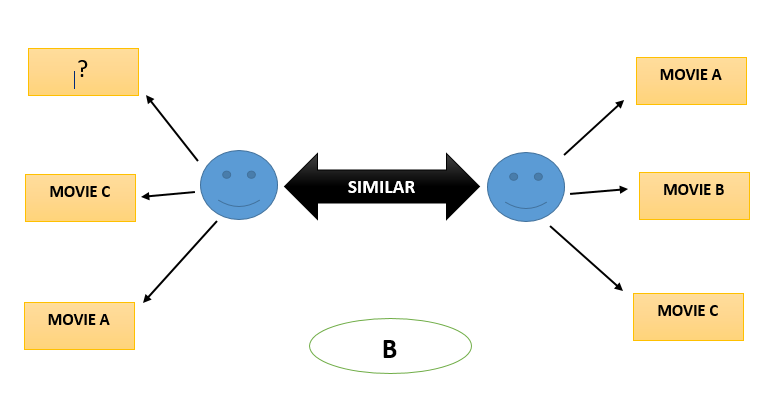

### Import TFRS

First, install and import TFRS:*italicized text*

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 85 kB 2.1 MB/s 
     |████████████████████████████████| 4.0 MB 12.6 MB/s 


In [ ]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import pprint
import matplotlib.pyplot as plt

## Preparing the dataset

Let's first have a look at the data.

We use the MovieLens dataset from [Tensorflow Datasets](https://www.tensorflow.org/datasets). Loading `movielens/100k_ratings` yields a `tf.data.Dataset` object containing the ratings data and loading `movielens/100k_movies` yields a `tf.data.Dataset` object containing only the movies data.

Note that since the MovieLens dataset does not have predefined splits, all data are under `train` split.

**Build vocabularies to convert user ids and movie titles into integer indices for embedding layers:** 

The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:

In [ ]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
ratingsFullDetail = tfds.load('movielens/100k-ratings', split="train")

for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.
{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [ ]:
movie_title_lookup = tf.keras.layers.StringLookup()
ratingsFullDetail=ratingsFullDetail.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_occupation": x["user_occupation_text"],
    "movie_genres": x["movie_genres"]
})

The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels.

In [ ]:
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.
{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


In this example, we're going to focus on the ratings data. Other tutorials explore how to use the movie information data as well to improve the model quality.

We keep only the `user_id`, and `movie_title` fields in the dataset.

In [ ]:

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

In [ ]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

### The full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines building models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [ ]:
class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)

Define the two models and the retrieval task.

In [ ]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)

## Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.



In [ ]:
# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))



Then train the  model:

In [ ]:
# Train for 10 epochs.
history=model.fit(ratings.batch(4096), epochs=200)

Epoch 1/200
25/25 [==============================] - 23s 866ms/step - factorized_top_k/top_1_categorical_accuracy: 1.3000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0017 - factorized_top_k/top_10_categorical_accuracy: 0.0053 - factorized_top_k/top_50_categorical_accuracy: 0.0457 - factorized_top_k/top_100_categorical_accuracy: 0.1014 - loss: 33080.4036 - regularization_loss: 0.0000e+00 - total_loss: 33080.4036
Epoch 2/200
25/25 [==============================] - 22s 874ms/step - factorized_top_k/top_1_categorical_accuracy: 2.8000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0145 - factorized_top_k/top_50_categorical_accuracy: 0.1053 - factorized_top_k/top_100_categorical_accuracy: 0.2119 - loss: 31007.7616 - regularization_loss: 0.0000e+00 - total_loss: 31007.7616
Epoch 3/200
25/25 [==============================] - 22s 868ms/step - factorized_top_k/top_1_categorical_accuracy: 5.5000e-04 - factorized_top_k/top_5_c

In [ ]:
history.history.keys()

dict_keys(['factorized_top_k/top_1_categorical_accuracy', 'factorized_top_k/top_5_categorical_accuracy', 'factorized_top_k/top_10_categorical_accuracy', 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy', 'loss', 'regularization_loss', 'total_loss'])

In [ ]:
# accuracy = history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
# print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.47.


In [ ]:
# loss = history.history["loss"][-1]
# print(f"Total loss: {loss:.2f}.")

Total loss: 10923.11.


200


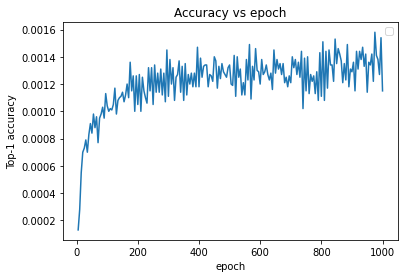

In [ ]:
num_validation_runs = len(history.history["factorized_top_k/top_1_categorical_accuracy"])
print(num_validation_runs)
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, history.history["factorized_top_k/top_1_categorical_accuracy"])
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-1 accuracy");
plt.legend()

##output of top_1_categorical_accuracy for 200 epochs


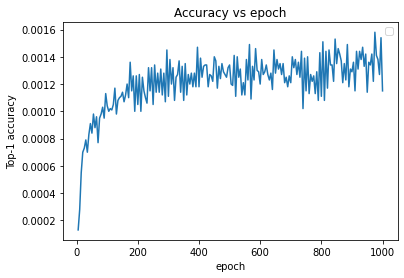

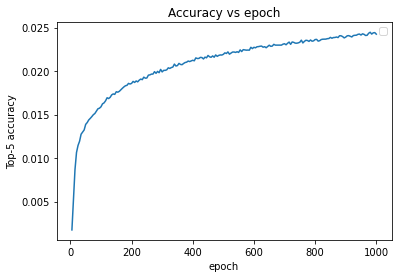

In [ ]:
plt.plot(epochs, history.history["factorized_top_k/top_5_categorical_accuracy"])
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-5 accuracy");
plt.legend()

##output of top_5_categorical_accuracy for 200 epochs

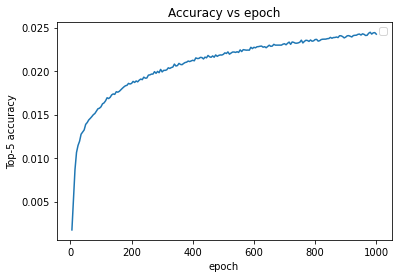

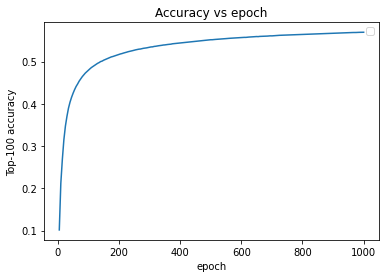

In [ ]:
plt.plot(epochs, history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

##output of top_100_categorical_accuracy for 200 epochs

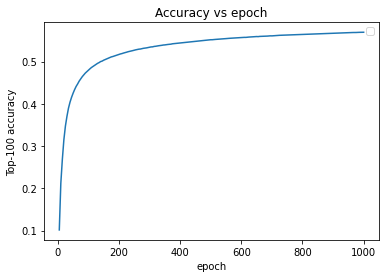

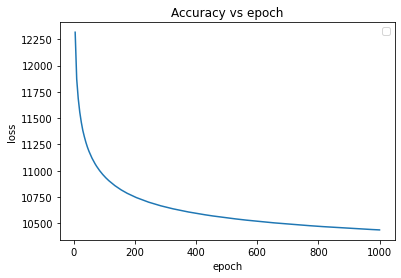

In [ ]:
plt.plot(epochs, history.history["loss"])
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("loss");
plt.legend()

##output of loss for 200 epochs

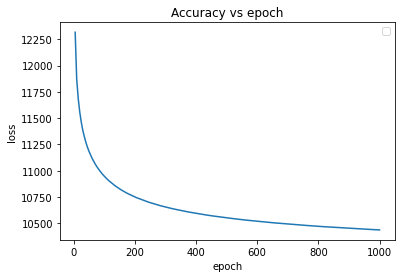

## Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [ ]:

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

In [ ]:
userID = 1
# converting to string 
str_val = str(userID) 

# converting string to bytes 
byte_val = str_val.encode() 

# print(index(np.array(["10"])))  
UsersMovieTitles=[]
# UsersMovieGenres=[]

for x in ratingsFullDetail.take(int(len(ratingsFullDetail)/2)).as_numpy_iterator():
  if x["user_id"] == byte_val:
      UsersMovieTitles.append(x["movie_title"].decode())
      # UsersMovieGenres.append(x["movie_genres"].decode())

pprint.pprint(UsersMovieTitles)
# pprint.pprint( UsersMovieGenres)



['2001: A Space Odyssey (1968)',
 'Belle de jour (1967)',
 'Jungle2Jungle (1997)',
 "What's Eating Gilbert Grape (1993)",
 'Sting, The (1973)',
 'Sneakers (1992)',
 'Unbearable Lightness of Being, The (1988)',
 'Good, The Bad and The Ugly, The (1966)',
 'Field of Dreams (1989)',
 'Event Horizon (1997)',
 'Starship Troopers (1997)',
 'So I Married an Axe Murderer (1993)',
 'Silence of the Lambs, The (1991)',
 'Twelve Monkeys (1995)',
 'Gattaca (1997)',
 'Shall We Dance? (1996)',
 'Babe (1995)',
 'French Twist (Gazon maudit) (1995)',
 'Free Willy (1993)',
 "My Best Friend's Wedding (1997)",
 'Wizard of Oz, The (1939)',
 'Kids in the Hall: Brain Candy (1996)',
 'Pulp Fiction (1994)',
 'Operation Dumbo Drop (1995)',
 "Weekend at Bernie's (1989)",
 'Star Trek III: The Search for Spock (1984)',
 'Return of the Jedi (1983)',
 'Reservoir Dogs (1992)',
 'Willy Wonka and the Chocolate Factory (1971)',
 'Delicatessen (1991)',
 'Angels and Insects (1995)',
 'Wrong Trousers, The (1993)',
 'Shanghai

In [ ]:
# Get some recommendations.
_, titles = index(np.array([str(userID)]))
print(f"recommendations for user {userID} are : {titles[0]}")

recommendations for user 1 are : [b'Theodore Rex (1995)' b'Maya Lin: A Strong Clear Vision (1994)'
 b'Brother Minister: The Assassination of Malcolm X (1994)'
 b'Turbo: A Power Rangers Movie (1997)' b'Doom Generation, The (1995)'
 b'Nadja (1994)' b'White Balloon, The (1995)'
 b'Faster Pussycat! Kill! Kill! (1965)' b'unknown'
 b'Unhook the Stars (1996)']
